In [3]:
import torch
import wandb
import pprint
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from copy import deepcopy as dpcp

In [4]:
import os
os.environ["http_proxy"]="http://proxy62.iitd.ac.in:3128"
os.environ["https_proxy"]="http://proxy62.iitd.ac.in:3128"

In [5]:
if torch.cuda.is_available():
  device = torch.device('cuda', index = 0)
else:
  device = 'cpu'

In [4]:
track_columns = ['new node test average_precision',
 'train roc_auc',
 'new node val first_3_roc_auc',
 'new node test first_3_roc_auc',
 'new node test first_3_average_precision',
 'new node val average_precision',
 'new node val first_1_average_precision',
 'new node test first_1_average_precision',
 'new node test first_1_roc_auc',
 'new node test first_10_roc_auc',
 'new node val first_3_average_precision',
 'val average_precision',
 'val roc_auc',
 'new node val roc_auc',
 'new node val first_10_average_precision',
 'new node test roc_auc',
 'train average_precision',
 'test roc_auc',
 'new node val first_1_roc_auc',
 'new node val first_10_roc_auc',
 'test average_precision',
 'new node test first_10_average_precision',
 'train_acc_hist',
 'val_acc_hist',
 'new node val_acc_hist',
 'test_acc_hist',
 'new node test_acc_hist',
 ]
import pandas as pd 
import wandb
api = wandb.Api()

runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib")

In [5]:
def update_run(run):
  if run.config['run_name'] == 'draft1':
    val_key = 'val average_precision'
    hist = run.history(samples = 200, keys = [val_key])
    hist= hist[val_key][:100]
    best_epoch_num_test = np.argmax(hist[9::10])
    best_epoch_num = np.argmax(hist)
    print(run.name)
    print(best_epoch_num)
    print(best_epoch_num_test)
    for key in track_columns:
      hist = run.history(samples = 200, keys = [key])[key]
      # print(f"From {run.summary[key]} to ", end ="")
      if 'test' in key:
        run.summary[key] = hist[best_epoch_num_test]
        # print(f"{run.summary[key]}")
      else:
        run.summary[key] = hist[best_epoch_num]
        # print(f"{run.summary[key]}")
    run.summary.update()

In [6]:
for run in tqdm(runs[:50]):
    update_run(run)

  0%|          | 0/50 [00:00<?, ?it/s]

tgn-ia-digg-reply-draft1
2
0
tgn-ia-escorts-dynamic-draft1
8
7
tgn-ia-slashdot-reply-dir-draft1
60
5
tgn-ia-movielens-user2tags-10m-draft1
6
0
tgn-ia-retweet-pol-draft1
22
0
tgn-ia-reality-call-draft1
92
6
tgn-ia-slashdot-reply-dir-draft1
95
0
tgn-ia-digg-reply-draft1
2
0
tgn-ia-movielens-user2tags-10m-draft1
6
6
tgn-ia-retweet-pol-draft1
4
1
tgn-ia-reality-call-draft1
93
8
tgn-ia-escorts-dynamic-draft1
6
1
tgn-ia-slashdot-reply-dir-draft1
0
0
tgn-ia-digg-reply-draft1
4
0
tgn-ia-movielens-user2tags-10m-draft1
12
0
tgn-ia-retweet-pol-draft1
66
0
tgn-ia-reality-call-draft1
95
6
tgn-ia-escorts-dynamic-draft1
78
6
tgn-ia-slashdot-reply-dir-draft1
0
0
tgn-ia-movielens-user2tags-10m-draft1
2
1
tgn-ia-digg-reply-draft1
1
5
tgn-ia-reality-call-draft1
35
3
tgn-ia-escorts-dynamic-draft1
8
0
tgn-ia-retweet-pol-draft1
5
0


## Table Generation

In [7]:
def get_table(filters, metrics, row_name):
  api = wandb.Api()
  runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib")
  # Retrieve relevant runs
  return_runs = []
  for run in runs:
    flag = True
    # if run.state in ['killed', 'failed']:
      # continue
    for filter_key, filter_val in filters.items():
      if 'use_init_method' not in run.config:
        flag = False
      elif filter_key == 'run_name' and run.config['use_init_method'] == False:
        run.config['init_weights'] = "old"
      elif type(filter_val) == str and filter_val not in run.config[filter_key]:
        flag = False
      elif type(filter_val) != str and run.config[filter_key] not in filter_val:
        flag = False
    if flag:
      return_runs.append(run)

  row_names = ["-".join([run.config[rn] for rn in row_name]) if row_name[0] in run.config else 'old' for run in return_runs ]
  for run in return_runs:
    if 'test average_precision' not in run.summary:
      x= 1
  return pd.DataFrame({metric: [round(100 * run.summary[metric], 2) for run in return_runs] for metric in metrics}, index = row_names)
def print_df_as_markdown(df):
    # Print header row
    df.sort_index(inplace = True)
    header = ["Index"] + list(df.columns)
    print("| " + " | ".join(header) + " |")
    
    # Print separator row
    print("| " + " | ".join([" --- " for _ in header]) + " |")
    
    # Print data rows
    for index, row in df.iterrows():
        data_row = [index]
        for col in df.columns:
            if row[col] == df[col].max():
                data_row.append("***" + str(row[col]) + "***")
            else:
                data_row.append(str(row[col]))
        print("| " + " | ".join(data_row) + " |")

In [8]:
data_names = ['ia-reality-call', 'ia-retweet-pol', 'ia-movielens-user2tags-10m', 'ia-slashdot-reply-dir', 'ia-escorts-dynamic', 'ia-digg-reply']
# data_names = ['wikipedia', 'reddit', 'lastfm']

In [9]:
for data_name in data_names:
  print(data_name)
  table = get_table({
    "run_name": ["rnd-attfus-el", "rnd-attfus-eld"],
    "dataset": data_name, 
    "model": "TGN"
    }, ["test average_precision", "new node test average_precision"], ["run_name"])
  print_df_as_markdown(table)

ia-reality-call
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | 97.3 | 94.69 |
| rnd-attfus-el | ***97.72*** | ***95.05*** |
| rnd-attfus-eld | 97.67 | 94.83 |
ia-retweet-pol
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | 89.88 | 75.3 |
| rnd-attfus-el | ***90.56*** | ***77.71*** |
| rnd-attfus-eld | 90.1 | 76.72 |
ia-movielens-user2tags-10m
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | 89.51 | 79.63 |
| rnd-attfus-el | 89.68 | 78.7 |
| rnd-attfus-eld | ***89.97*** | ***80.76*** |
ia-slashdot-reply-dir
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | 89.46 | 87.12 |
| rnd-attfus-el | ***92.4*** | 84.74 |
| rnd-attfus-eld | 90.15 | ***87.22*** |
ia-escorts-dynamic
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | 88.

In [ ]:
for data_name in data_names:
  print(data_name)
  table = get_table({"run_name": "0204", "dataset": data_name}, ["test average_precision", "new node test average_precision"], ["init_weights"])
  print_df_as_markdown(table)

| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | 97.3 | 94.69 |
| time-exp | ***97.89*** | ***95.15*** |
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | 89.88 | 75.3 |
| time-exp | ***90.29*** | ***75.83*** |
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | ***89.51*** | ***79.63*** |
| time-exp | 89.5 | 79.41 |
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | ***89.46*** | ***87.12*** |
| time-exp | 86.15 | 74.08 |
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | 88.26 | 74.14 |
| time-exp | ***88.69*** | ***75.59*** |
| Index | test average_precision | new node test average_precision |
|  ---  |  ---  |  ---  |
| old | 80.91 | ***65.63*** |
| time-exp | ***82.43*** | 65.56 |


# Plotting time transformation function

In [8]:
import sys
sys.path += ['/home/ayush/DyGLib/']
from models.MemoryModel import *
data_names = ['ia-reality-call', 'ia-retweet-pol', 'ia-movielens-user2tags-10m', 'ia-slashdot-reply-dir', 'ia-escorts-dynamic', 'ia-digg-reply']
num_nodes = [27046, 18471, 16530, 51085, 10108, 30400]

def plot_all(call = 'exp', init_weights = 'time-exp', name = 'maint', initial = False, number = 0):
  data_name = data_names[number]
  num_node = num_nodes[number]
  run_name = "TGN_seed0_" + data_name + f"{name}-{init_weights}"
  save_model_path = f"/home/ayush/DyGLib/saved_models/TGN/{data_name}/TGN_seed0_tgn-{data_name}-{name}-{init_weights}/TGN_seed0_tgn-{data_name}-{name}-{init_weights}.pkl"
  dynamic_backbone = MemoryModel(node_raw_features=np.zeros((num_node, 172)), edge_raw_features=np.zeros((1720, 172)), neighbor_sampler = None, time_feat_dim=100, model_name="TGN", num_layers=1, num_heads=2, dropout=0.1, min_time=1, use_init_method=True, init_weights=init_weights, total_time=0, device=device)
  dynamic_backbone.mlp_for_mean = nn.Sequential(
              nn.Linear(dynamic_backbone.memory_dim, dynamic_backbone.memory_dim)
          )
  link_predictor = MergeLayer(
                  input_dim1=172,
                  input_dim2=172,
                  hidden_dim=172,
                  output_dim=1,
              )
  model = nn.Sequential(dynamic_backbone, link_predictor)
  if True:
  # try:
    if not initial:
      model.load_state_dict(torch.load(save_model_path, map_location=None), strict=False)
    x = (torch.arange(0, 500)/500).reshape(-1, 1)
    tt = model[0].time_transformation_for_init
    if call == 'exp':
      lin_out = tt.lin(-x).reshape(-1)
      y = torch.exp(-torch.square(lin_out))
    if call == 'linear':
      y = tt.lin(-x).reshape(-1)
    if call == 'quad':
      y = tt.lin(torch.cat((-x.reshape(-1, 1), torch.pow(-x, 2).reshape(-1, 1)), dim = 1)).reshape(-1)
    if call == 'cubic':
      y = tt.lin(torch.cat((-x.reshape(-1, 1), torch.pow(-x, 2).reshape(-1, 1), torch.pow(-x, 3).reshape(-1, 1)), dim = 1)).reshape(-1)
    if call == 'fourier':
      zeros = -x.reshape(-1, 1)
      exp_out = (torch.cos(zeros.unsqueeze(-1) * tt.mask.unsqueeze(0).unsqueeze(1)) * tt.lin[:tt.k]).sum(dim = 2) + torch.sin(zeros.unsqueeze(-1) * tt.mask.unsqueeze(0).unsqueeze(1)  * tt.lin[tt.k:]).sum(dim = 2)
      y = exp_out.reshape(-1)
    if call == 'mlp' or call == 'mlp2':
      y = tt.mlp_for_time(-x.reshape(-1, 1)).reshape(-1)
    if call == '3unite':
      lin_out = tt.exp.lin(-x).reshape(-1)
      y1 = tt.lamb1 * torch.exp(-torch.square(lin_out))
      y2 = tt.lamb2 * tt.linear.lin(-x).reshape(-1)
      y3 = tt.lamb3
      y = y1 + y2 + y3
      print(data_name)
      print(tt.lamb1.item(), tt.lamb2.item(), tt.lamb3.item())
    if call == 'context':
      # importing required libraries 
      from mpl_toolkits.mplot3d import Axes3D
      t_factor = torch.arange(0, 1, 0.05)
      i1, i2 = torch.meshgrid(-x.flatten(), t_factor.flatten())
      y = tt.lin(torch.cat((i1.unsqueeze(2), i2.unsqueeze(2)), dim = 2)).reshape(i1.shape[0], i1.shape[1]).detach()
      # for creating a responsive plot 
      %matplotlib widget
      fig = plt.figure()
      ax = Axes3D(fig) 
      ax.scatter((1 + i1).tolist(), i2.tolist(), y.tolist(), color ='green')
      ax.set_xlabel('Edge time')
      ax.set_ylabel('Current time')
      ax.set_zlabel('Value')
      plt.show()
    if call != 'context':
      plt.plot((1 - x).tolist(), y.tolist())
    return True
  # except Exception as e:
  #   print(e)
  #   return False
  
  
def plot_all_all(call = 'exp', name = 'maint'):
  legends = []
  mask = plot_all(call=f'{call}', init_weights=f'time-{call}', name = name, initial = True, number=0)
  if mask:
    legends.append('initial')
  for j in range(6):
    mask = plot_all(call=f'{call}', init_weights=f'time-{call}', name = name, number=j)
    if mask:
      legends.append(data_names[j])
  plt.title(f'{name}: time-{call}')
  plt.legend(legends)
  plt.xlabel(r'Time t: Earliest $\rightarrow$$\rightarrow$$\rightarrow$$\rightarrow$ current')
  plt.ylabel(r'Weight $w(t)$')
  plt.show()
  plt.close()

ia-reality-call
0.035902172327041626 0.2086746096611023 0.44206133484840393
ia-reality-call
1.33086359500885 0.8570681214332581 1.2150648832321167
ia-retweet-pol
1.2229266166687012 0.9675735235214233 1.1063944101333618
ia-movielens-user2tags-10m
1.212335467338562 0.9783283472061157 1.0961400270462036
ia-slashdot-reply-dir
1.193485140800476 0.9972187876701355 1.0772465467453003
ia-escorts-dynamic
1.19044828414917 1.0002371072769165 1.0743359327316284
ia-digg-reply
1.209999680519104 0.98064124584198 1.0934653282165527


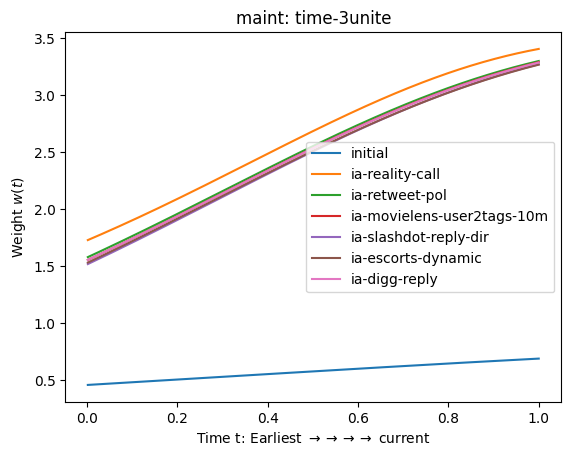

In [9]:
plot_all_all('3unite', 'maint')

ia-reality-call
0.3992280066013336 1.5057495832443237 0.4891194999217987
ia-reality-call
1.347365379333496 0.8404911756515503 1.2317367792129517
ia-retweet-pol
1.211748719215393 0.9789043664932251 1.09531569480896
ia-movielens-user2tags-10m
1.2174487113952637 0.9731689691543579 1.1013765335083008
ia-slashdot-reply-dir
1.1929221153259277 0.9977792501449585 1.076682209968567
ia-escorts-dynamic
1.1899185180664062 1.0007871389389038 1.0738356113433838
ia-digg-reply
1.2039591073989868 0.9867066740989685 1.0875903367996216


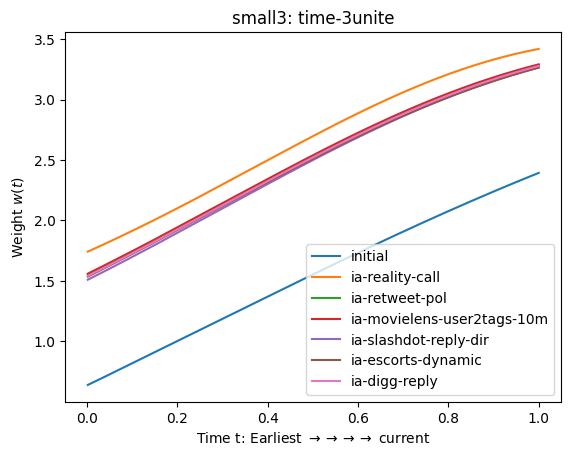

In [10]:
plot_all_all('3unite', 'small3')

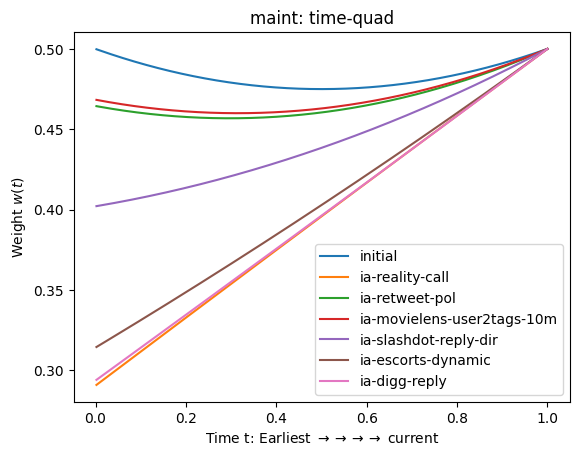

In [24]:
plot_all_all('quad')

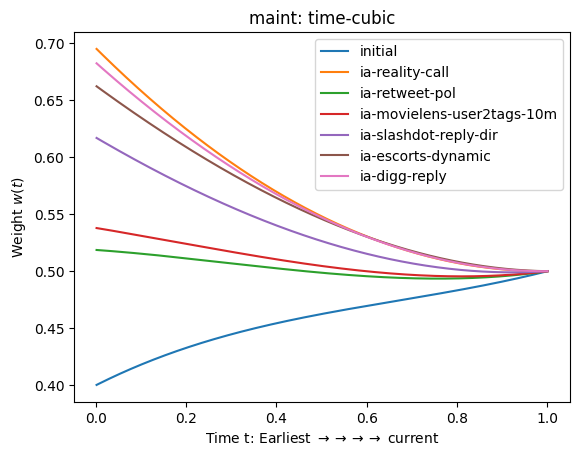

In [19]:
plot_all_all('cubic')

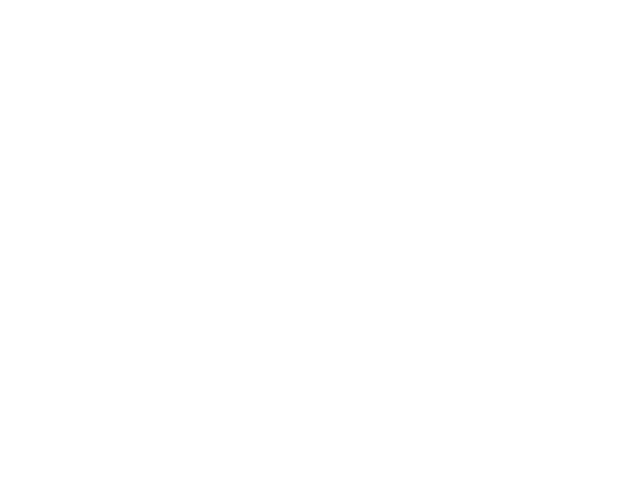

True

In [7]:
# creating 3d plot using matplotlib  
# in python 
plot_all(call = 'context', init_weights = 'time-context', name = 'maint', number = 0, initial = True)

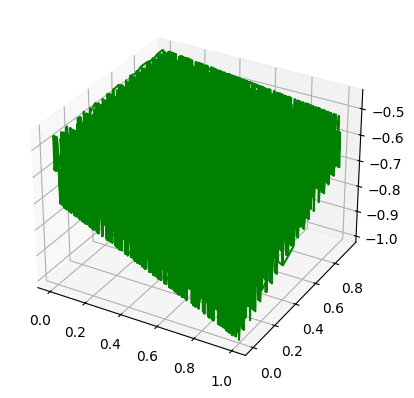

True

In [52]:
plot_all(call = 'context', init_weights = 'time-context', name = 'ctx-mlp', initial = False, number = 0)

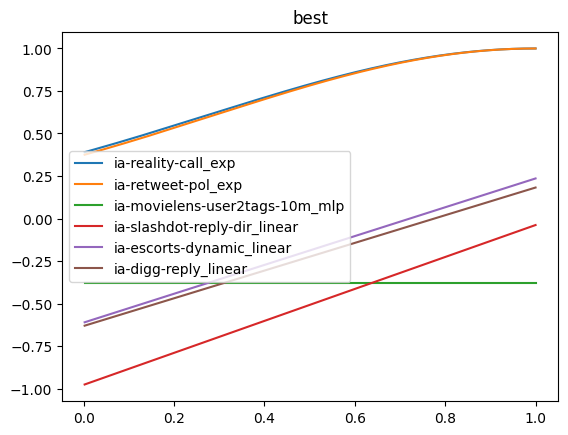

: 

In [10]:
best_ones = ['exp', 'exp', 'mlp', 'linear', 'linear', 'linear']
for i in range(6):
  plot_all(best_ones[i], f'time-{best_ones[i]}', i)
plt.legend([f'{data_names[i]}_{best_ones[i]}' for i in range(6)])
plt.title('best')
plt.show()

### Paper: Generate histogram and find correlation

In [19]:
def gen_hist():
  api = wandb.Api()
  runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib")
  # print(len(filt_runs), [run.id for run in filt_runs])
  data_names = ['ia-reality-call', 'ia-retweet-pol', 'ia-movielens-user2tags-10m', 'ia-slashdot-reply-dir', 'ia-escorts-dynamic', 'ia-digg-reply']
  for dataset in data_names:
    filt_runs = [run for run in runs if run.config['model'] in ['TGN', 'DyGFormer'] and run.config['run_name'] == 'old' and run.config['dataset'] == dataset][:2]
    for hist_name in ['test_acc_hist', 'new node test_acc_hist']:
      plt.figure(figsize= (8, 6))
      plt.title(f"{hist_name} for {filt_runs[0].config['model']} on {dataset[0]}")
      val_arr = []
      for run in filt_runs:
        hist = run.summary[hist_name]
        vals, bins = hist['values'], hist['bins']
        vals = [float(val) for val in vals]
        vals = smooth(torch.tensor(vals))
        val_arr.append(vals)
        plt.plot(bins[1:], vals)
      plt.ylim([np.nanmin([np.nanmin(vals) for vals in val_arr]), 1])
      # plt.stackplot(bins[1:], val_arr[0], val_arr[1], step='post', labels=["-".join(run.name.split("-")[5:]) for run in filt_runs])
      # plt.hist(val_arr, bins = bins, stacked=True, color = ['red', 'orange', 'green', 'blue', 'grey'], label=["-".join(run.name.split("-")[5:]) for run in filt_runs])
      plt.legend(labels=[run.config['model'] for run in filt_runs])
      plt.show()
      plt.close()

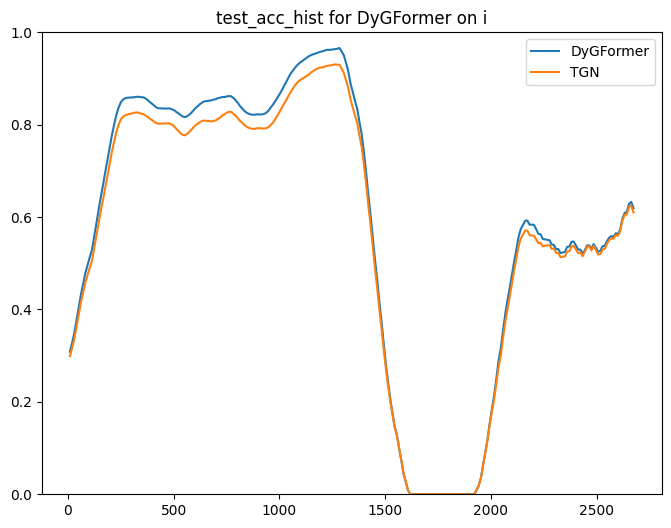

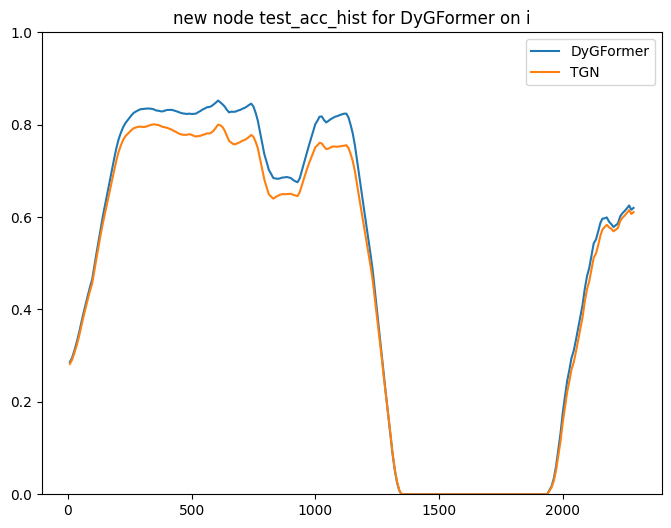

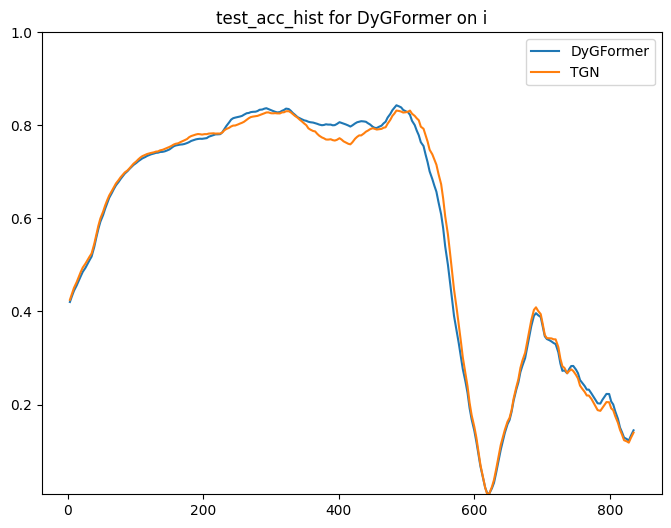

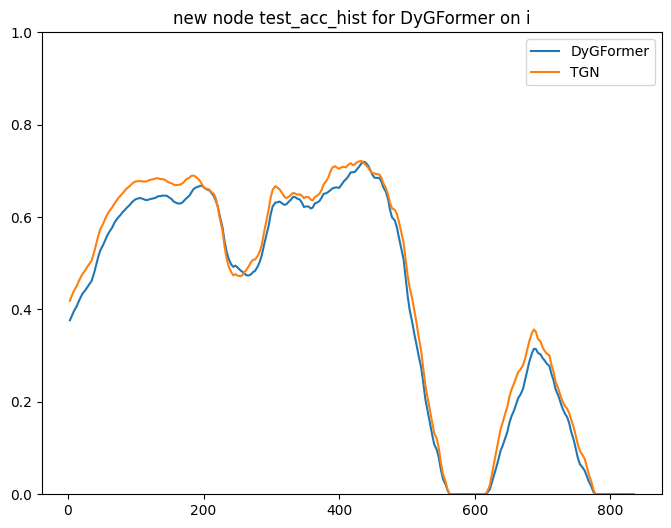

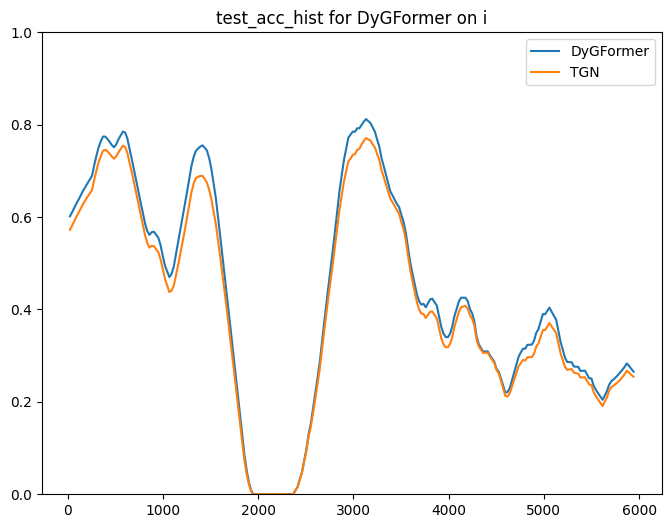

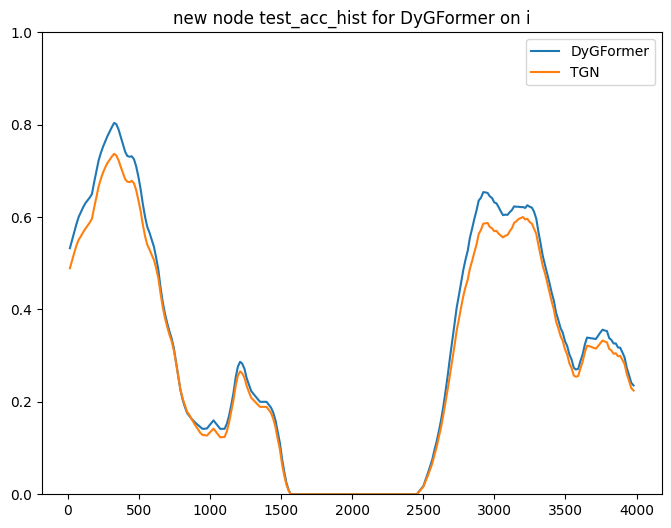

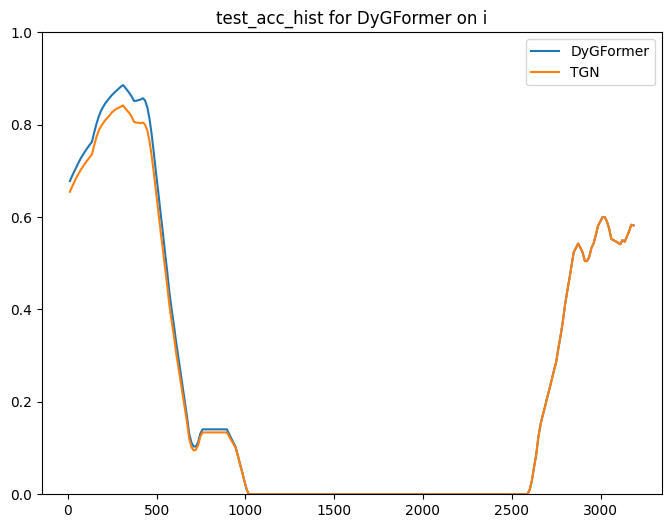

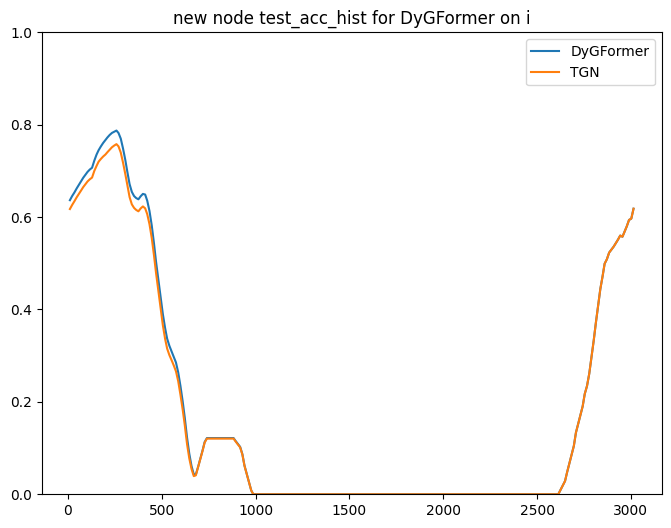

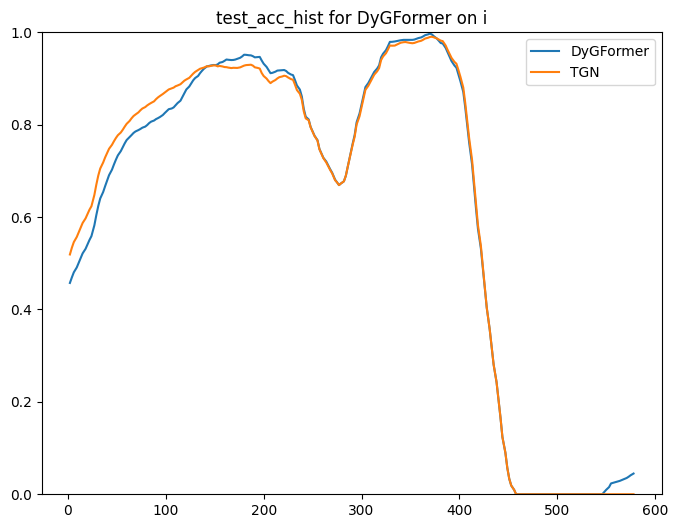

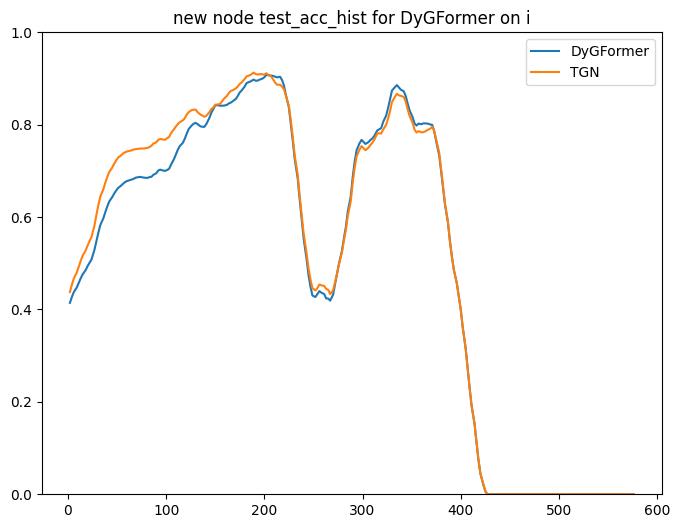

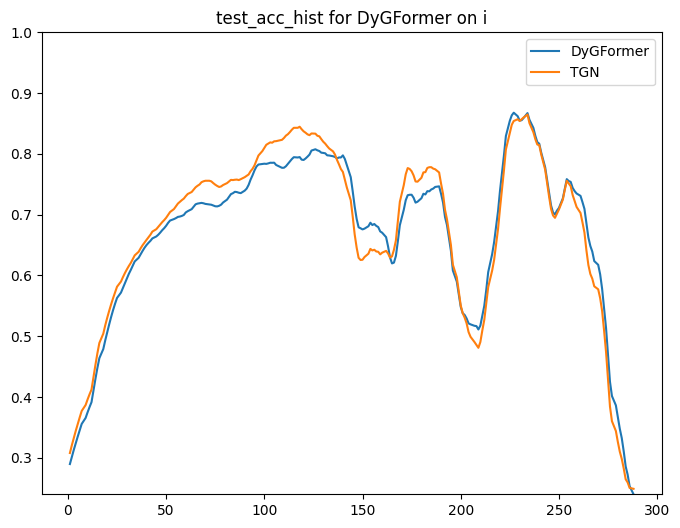

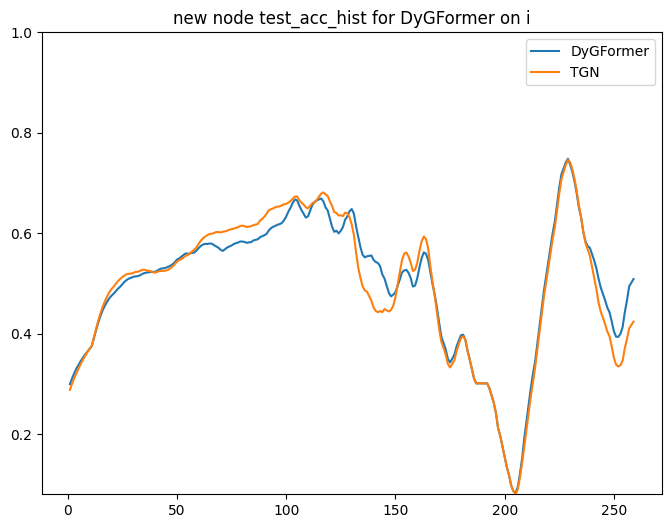

In [20]:
gen_hist()

## Generating combined histogram of acc v/s count for all nodes.

In [11]:
def smooth(tensor):
  smoothed_tensor = tensor.clone()
  for idx in range(len(tensor)):
    start_index = max(0, idx - 10)
    end_index = min(len(tensor), idx + 11)  # Adjusted to include the 10 elements after NaN
    
    # Smooth values using surrounding indices
    smoothed_value = torch.nanmean(tensor[start_index:end_index])
    
    # Replace NaN value with smoothed value
    smoothed_tensor[idx] = smoothed_value
  return smoothed_tensor.numpy()

In [6]:
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import torch

def generate_combine_hists(data_name):
  api = wandb.Api()
  runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib")
  filt_runs = [run for run in runs if run.config['dataset'] == data_name][:5]
  # print(len(filt_runs), [run.id for run in filt_runs])
  for hist_name in ['test_acc_hist', 'new node test_acc_hist']:
    plt.figure(figsize= (8, 6))
    plt.title(f"{hist_name} for {filt_runs[0].config['dataset']}")
    val_arr = []
    for run in filt_runs:
      hist = run.summary[hist_name]
      vals, bins = hist['values'], hist['bins']
      vals = [float(val) for val in vals]
      # vals = smooth(torch.tensor(vals))
      val_arr.append(np.array(vals))
      plt.plot(bins[1:], vals)
    plt.ylim([np.nanmin([np.nanmin(vals) for vals in val_arr]), 1])
    # plt.stackplot(bins[1:], val_arr[0], val_arr[1], step='post', labels=["-".join(run.name.split("-")[5:]) for run in filt_runs])
    # plt.hist(val_arr, bins = bins, stacked=True, color = ['red', 'orange', 'green', 'blue', 'grey'], label=["-".join(run.name.split("-")[5:]) for run in filt_runs])
    plt.legend(labels=["-".join(run.name.split("-")[len(data_name.split("-")) + 1:]) for run in filt_runs])
    plt.show()
    plt.close()

0
24
18
10
0


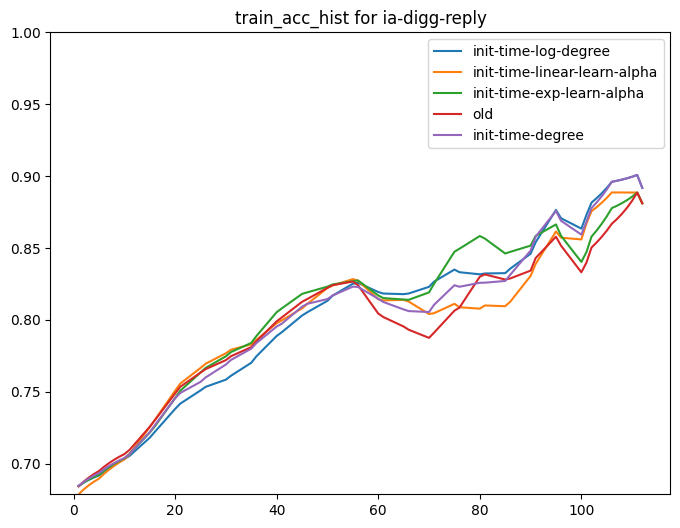

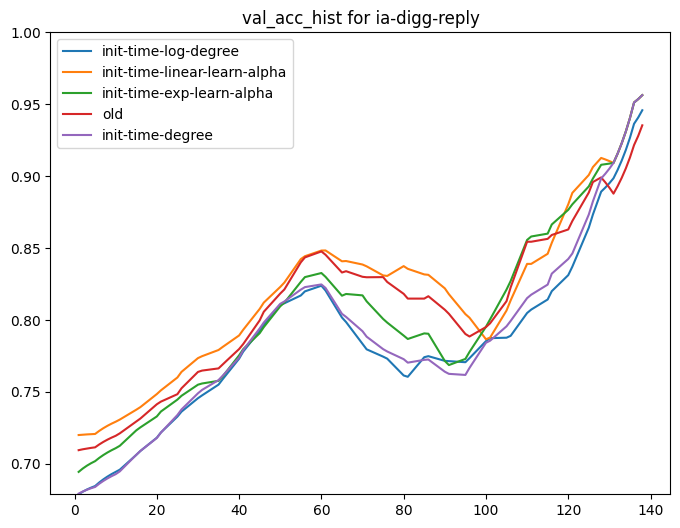

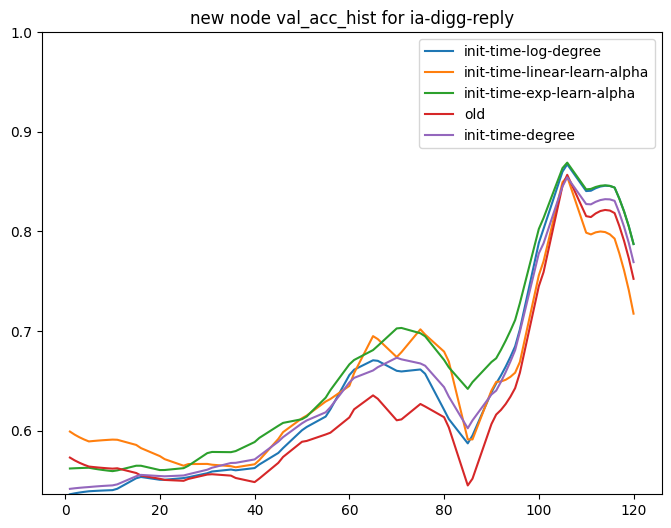

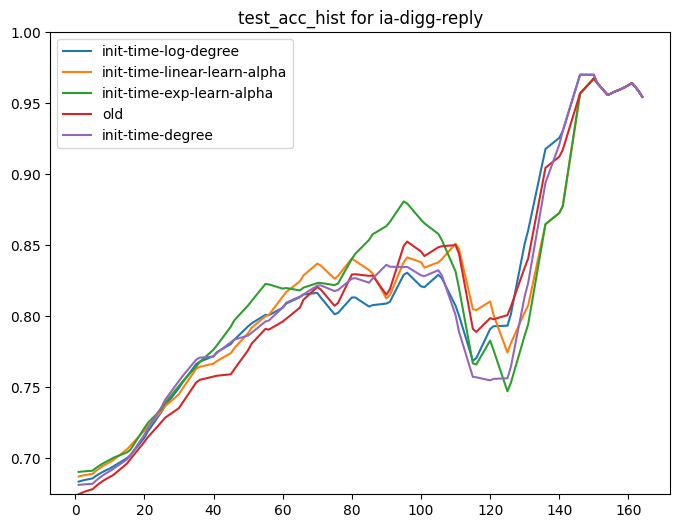

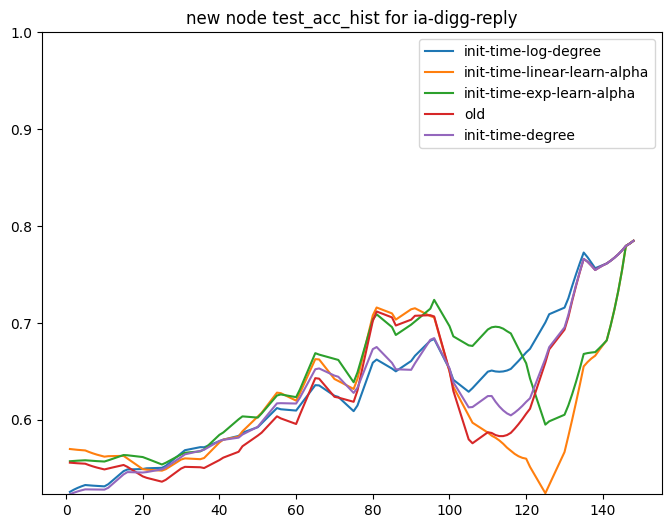

In [56]:
data_name = 'ia-digg-reply'
generate_combine_hists(data_name)

In [18]:
api = wandb.Api()
run = api.run(f"/fb-graph-proj/fb-graph-proj-dyglib/runs/jpp7vme0")
print(run.summary)
run.summary['test_loss'] = 0.2658
run.summary.update()

{'_timestamp': 1704864622.8613284, 'train_loss': {'min': 0.23194398468571345}, 'new node val average_precision': 0.9253885944374476, 'new node test average_precision': 0.9365360489713036, '_step': 41, 'test_loss': 0.2658, 'val average_precision': 0.9642710623015756, 'test average_precision': 0.9598691819415296, 'test roc_auc': {'max': 0.957818487394958}, 'train roc_auc': {'max': 0.9642339940649474}, 'new node test roc_auc': {'max': 0.9301795424690014}, 'train average_precision': 0.9642710623015756, '_wandb': {'runtime': 1468}, 'new node val_loss': {'min': 0.35462927964867136}, 'val roc_auc': {'max': 0.9642339940649474}, 'new node test loss': 0.3415547061269566, 'new node val roc_auc': {'max': 0.9190259221311476}, '_runtime': 1449.64683842659, 'val_loss': {'min': 0.255154035046321}}


In [10]:
import pandas as pd 
import wandb
api = wandb.Api()

runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib", filters = {'dataset': "reddit"})

In [22]:
import pandas as pd
from io import StringIO

def markdown_table_with_colored_top3(markdown_table):
    # Convert Markdown table to DataFrame
    df = pd.read_csv(StringIO(markdown_table), sep="|", skipinitialspace=True)
    df = df.dropna(axis=1, how='all')  # Drop columns if they are completely NA
    df = df.dropna()  # Drop rows that are completely NA

    # Clean column names and reset index
    df.columns = df.columns.str.strip()
    df['Index'] = df['Index'].str.strip()
    df.set_index('Index', inplace=True)
    
    # Function to apply coloring
    def color_top3(s):
        is_numeric_col = pd.to_numeric(s, errors='coerce').notnull().all()
        # Apply coloring only if column is numeric
        if is_numeric_col:
            top3_vals = s.astype(float).nlargest(3)
            colors = {top3_vals.index[0]: 'yellow', top3_vals.index[1]: 'LightGreen', top3_vals.index[2]: 'SkyBlue'}
            return s.index.map(lambda x: f'<span style="color:{colors.get(x, "none")};" markdown="1">{s.loc[x]}</span>' if x in top3_vals.index else s.loc[x])
        else:
            return s
    
    # Apply coloring and maintain DataFrame structure
    df_colored = df.apply(color_top3)
    
    # Constructing the Markdown table with HTML tags for coloring
    # Since direct DataFrame to_markdown conversion will escape HTML, we build it manually
    markdown_output = "|Index" + "| " + " | ".join(df_colored.columns) + " |\n"
    markdown_output += "|-" + "-|-".join(["" for _ in range(len(df_colored.columns)+1)]) + "-|\n"
    for index, row in df_colored.iterrows():
        markdown_output += "|" + index + "| " + " | ".join([str(val) for val in row]) + " |\n"

    return markdown_output

# Your markdown table input
markdown_table = """
| Index  | Reality | Retweet | Movielens | Slashdot   | Escorts     | Digg       |
| Normal | 87.56   | 66.54   | 65.01     | 60.08      | 71.68       | 56.42      |
| Exp    | 87.39   | 65.02   | 62.19     | 61.8 | 72.64 | 56.8 |
| Linear | 86.26   | 0       | 65.37     | 57.43      | 71.92       | 55.71      |
"""

# Use the function
colored_markdown = markdown_table_with_colored_top3(markdown_table)
print(colored_markdown)


|Index| Reality | Retweet | Movielens | Slashdot | Escorts | Digg |
|--|--|--|--|--|--|--|
|Normal| <span style="color:yellow;" markdown="1">87.56</span> | <span style="color:yellow;" markdown="1">66.54</span> | <span style="color:LightGreen;" markdown="1">65.01</span> | <span style="color:LightGreen;" markdown="1">60.08</span> | <span style="color:SkyBlue;" markdown="1">71.68</span> | <span style="color:LightGreen;" markdown="1">56.42</span> |
|Exp| <span style="color:LightGreen;" markdown="1">87.39</span> | <span style="color:LightGreen;" markdown="1">65.02</span> | <span style="color:SkyBlue;" markdown="1">62.19</span> | <span style="color:yellow;" markdown="1">61.8</span> | <span style="color:yellow;" markdown="1">72.64</span> | <span style="color:yellow;" markdown="1">56.8</span> |
|Linear| <span style="color:SkyBlue;" markdown="1">86.26</span> | <span style="color:SkyBlue;" markdown="1">0.0</span> | <span style="color:yellow;" markdown="1">65.37</span> | <span style="color:SkyBlu

In [11]:
import pandas as pd
import re
from io import StringIO

def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def markdown_table_with_colored_top3(markdown_table):
    # Step 1: Preprocess the markdown table to remove HTML tags
    cleaned_markdown_table = "\n".join([remove_html_tags(line) for line in markdown_table.split("\n")])

    # Convert cleaned Markdown table to DataFrame
    df = pd.read_csv(StringIO(cleaned_markdown_table), sep="|", skipinitialspace=True)
    df = df.dropna(axis=1, how='all')  # Drop columns if they are completely NA
    df = df.dropna()  # Drop rows that are completely NA

    # Clean column names and reset index
    df.columns = df.columns.str.strip()
    df['Index'] = df['Index'].str.strip()
    df.set_index('Index', inplace=True)

    # Function to apply coloring
    def color_top3(s):
        is_numeric_col = pd.to_numeric(s, errors='coerce').notnull().all()
        # Apply coloring only if column is numeric
        if is_numeric_col:
            top3_vals = s.astype(float).nlargest(3)
            colors = {top3_vals.index[0]: 'yellow', top3_vals.index[1]: 'LightGreen', top3_vals.index[2]: 'SkyBlue'}
            return s.index.map(lambda x: f'<span style="color:{colors.get(x, "none")};" markdown="1">{s.loc[x]}</span>' if x in top3_vals.index else s.loc[x])
        else:
            return s

    # Apply coloring and maintain DataFrame structure
    df_colored = df.apply(color_top3)
    
    # Constructing the Markdown table with HTML tags for coloring
    markdown_output = "|Index" + "| " + " | ".join(df_colored.columns) + " |\n"
    markdown_output += "|-" + "-|-".join(["" for _ in range(len(df_colored.columns)+1)]) + "-|\n"
    for index, row in df_colored.iterrows():
        markdown_output += "|" + index + "| " + " | ".join([str(val) for val in row]) + " |\n"


    return markdown_output

# Your markdown table input with some HTML spans
markdown_table_with_spans = """| Index  | Reality                                                   | Retweet                                                   | Movielens                                                 | Slashdot                                                  | Escorts                                                  | Digg                                                      |
| Normal | <span style="color:SkyBlue;" markdown="1">97.3</span>     | <span style="color:LightGreen;" markdown="1">89.88</span> | <span style="color:yellow;" markdown="1">89.51</span>     | <span style="color:LightGreen;" markdown="1">89.46</span> | <span style="color:SkyBlue;" markdown="1">88.26</span>   | <span style="color:SkyBlue;" markdown="1">80.91</span>    |
| Exp    | <span style="color:yellow;" markdown="1">97.73</span>     | <span style="color:yellow;" markdown="1">91.66</span>     | <span style="color:SkyBlue;" markdown="1">89.33</span>    | <span style="color:SkyBlue;" markdown="1">85.25</span>    | <span style="color:LightGreen;" markdown="1">89.4</span> | <span style="color:LightGreen;" markdown="1">82.04</span> |
| Linear | <span style="color:LightGreen;" markdown="1">97.67</span> | <span style="color:SkyBlue;" markdown="1">86.4</span>     | <span style="color:LightGreen;" markdown="1">89.38</span> | <span style="color:yellow;" markdown="1">91.35</span>     | <span style="color:yellow;" markdown="1">89.89</span>    | <span style="color:yellow;" markdown="1">82.83</span>     |
| EL     | 97.72                                               | 90.56                                               | 89.68                                                     | 92.4                                                | 90.21                                              | 83.25                                               |
| ELD    | 97.67                                                     | 90.1                                                      | 89.97                                               | 90.15                                                     | 90.21                                              | 83.11                                                     |
"""

# Use the function
colored_markdown = markdown_table_with_colored_top3(markdown_table_with_spans)
print(colored_markdown)

|Index| Reality | Retweet | Movielens | Slashdot | Escorts | Digg |
|--|--|--|--|--|--|--|
|Normal| 97.3 | 89.88 | <span style="color:SkyBlue;" markdown="1">89.51</span> | 89.46 | 88.26 | 80.91 |
|Exp| <span style="color:yellow;" markdown="1">97.73</span> | <span style="color:yellow;" markdown="1">91.66</span> | 89.33 | 85.25 | 89.4 | 82.04 |
|Linear| <span style="color:SkyBlue;" markdown="1">97.67</span> | 86.4 | 89.38 | <span style="color:LightGreen;" markdown="1">91.35</span> | <span style="color:SkyBlue;" markdown="1">89.89</span> | <span style="color:SkyBlue;" markdown="1">82.83</span> |
|EL| <span style="color:LightGreen;" markdown="1">97.72</span> | <span style="color:LightGreen;" markdown="1">90.56</span> | <span style="color:LightGreen;" markdown="1">89.68</span> | <span style="color:yellow;" markdown="1">92.4</span> | <span style="color:yellow;" markdown="1">90.21</span> | <span style="color:yellow;" markdown="1">83.25</span> |
|ELD| 97.67 | <span style="color:SkyBlue;" markd

In [14]:
def parse_string_to_list(input_string):
    """
    Parses a string of format "Label value1 value2 value3 ..."
    to extract the numerical values into a list.
    """
    # Split the string by spaces and extract the values after the label
    values = input_string.split()[1:]
    # Convert the string values to floats
    numeric_values = [float(value) for value in values]
    return numeric_values

def calculate_average_pairwise_difference(string1, string2):
    """
    Takes two strings of numerical values, converts them to lists,
    calculates the pairwise differences, and returns the average difference.
    """
    # Parse the input strings to lists of numeric values
    list1 = parse_string_to_list(string1)
    list2 = parse_string_to_list(string2)
    
    # Calculate pairwise differences
    pairwise_differences = [b - a for a, b in zip(list1, list2)]
    
    # Calculate and return the average difference
    average_difference = sum(pairwise_differences) / len(pairwise_differences)
    return average_difference

# Example input strings
normal_string = "Normal 97.3 89.88 89.51 89.46 88.26 80.91"
exp_string = "BOB 97.73 91.66 89.38 91.35 89.89 82.83"
# Calculate and print the average pairwise difference
average_diff = calculate_average_pairwise_difference(normal_string, exp_string)
print(f"Average pairwise difference: {average_diff}")

Average pairwise difference: 1.2533333333333327
